# Metapath-visits HGCN


- Goal here is to take the embedding of the GNN model and create Graph > spectral clustering > survival analysis 
- and compare with SNF results.

In [1]:
import numpy as np
import pandas as pd
import os
import networkx as nx 
from torch_geometric.utils.convert import from_networkx
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.optimize import minimize



In [2]:
folder_path = 'Data/MIMIC resources'

df_Admissions = pd.read_csv(f'{folder_path}/ADMISSIONS.csv')

df_Patients = pd.read_csv(f'{folder_path}/PATIENTS.csv')

# medication!
df_Prescription = pd.read_csv(f'{folder_path}/PRESCRIPTIONS.csv')

# Diagnosis!
df_DiagnosisICD = pd.read_csv(f'{folder_path}/DIAGNOSES_ICD.csv')

# Procedures!
df_ProceduresICD = pd.read_csv(f'{folder_path}/PROCEDURES_ICD.csv')
# ICUStays
df_Icustays = pd.read_csv(f'{folder_path}/ICUSTAYS.csv')


df_ProceduresICD.dropna(subset=['ICD9_CODE'], inplace=True)
df_Prescription.dropna(subset=['drug'], inplace=True)
df_DiagnosisICD.dropna(subset=['ICD9_CODE'], inplace=True)

In [3]:
# convert all procedure codes into two digits only
# convert all diagnosis codes into three digits only

def extract3(code):
    return str(code)[:3]
def extract2(code):
    return str(code)[:2]

df_DiagnosisICD['ICD9_CODE'] = df_DiagnosisICD['ICD9_CODE'].apply(extract3)
df_ProceduresICD['ICD9_CODE'] = df_ProceduresICD['ICD9_CODE'].apply(extract2)

df_ProceduresICD


,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,944,62641,154460,3,34
1,945,2592,130856,1,96
2,946,2592,130856,2,38
3,947,55357,119355,1,96
4,948,55357,119355,2,33
...,...,...,...,...,...
240090,228330,67415,150871,5,37
240091,228331,67415,150871,6,38
240092,228332,67415,150871,7,88
240093,228333,67415,150871,8,38


In [4]:
Procedures = sorted(df_ProceduresICD['ICD9_CODE'].unique())
Medication = sorted(df_Prescription['drug'].unique())
Diagnosis  = df_DiagnosisICD['ICD9_CODE'].unique()
Patients = df_Patients['SUBJECT_ID'].unique()
Admissions = df_Admissions['HADM_ID'].unique()

print(f'Number of Patients = {len(Patients)}')

print(f'Number of Admissions = {len(Admissions)}')

print(f'Number of Diagnosis = {len(Diagnosis)}')

print(f'Number of procedures = {len(Procedures)}')

print(f'Number of Medication = {len(Medication)}')

Number of Patients = 46520
Number of Admissions = 58976
Number of Diagnosis = 942
Number of procedures = 89
Number of Medication = 592


# LUNG Patients only
**ICD9=162**

## Extracting visits (admissions) of each patient sorted by its date.

In [5]:
def getDict(A, DF, label1, label2):
    # Extracting the list of NODES for each A item. 
    # Filter the dataframe to extract Nodes associated with the specified label1
    # Extract the list of Nodes associated with the patient
    D = {}
    for v in A:
        df = DF[DF[label1] == v]
        id_list = df[label2].tolist()
        if len(id_list)>0:
            D[v] = id_list
    
    return D

# def getNodes_and_Edges(D):
#     DNodes, DEdges = [], []
#     for i, v in D.items():
#         for j in v:
#             if isinstance(j, (int, float, str)) and not np.isnan(j):
#                 DEdges.append([i,j])
#                 if j not in DNodes:
#                     DNodes.append(j)
#     return DNodes, DEdges

def getNodes_and_Edges(D):
    DEdges = []
    DNodes = []
    for i, v in D.items():
        for j in v:
            if isinstance(j, (int, float)) and not np.isnan(j):
                DEdges.append([i, j])
                if j not in DNodes:
                    DNodes.append(j)
            elif isinstance(j, str):
                # Check if it's a valid numeric string before treating it as a node
                try:
                    numeric_value = float(j)
                    DEdges.append([i, numeric_value])
                    if numeric_value not in DNodes:
                        DNodes.append(numeric_value)
                except ValueError:
                    # If it's not a valid numeric string, treat it as a regular string node
                    DEdges.append([i, j])
                    if j not in DNodes:
                        DNodes.append(j)
    return DNodes, remove_red(DEdges)

def remove_red(DEdges):
    f = []
    for u,v in DEdges:
        if [u,v] not in f:
            f.append([u,v])
    return f


In [6]:
# # restricting to LUNG disease
# ICD_Diagnosis_Lung = [i for i in Diagnosis if str(i).startswith('162')]

df_sub = df_DiagnosisICD[df_DiagnosisICD['ICD9_CODE'].str.startswith('162')]

df_sub = df_sub[['SUBJECT_ID',	'HADM_ID']].dropna(subset=['HADM_ID'])
df_sub

,SUBJECT_ID,HADM_ID
584,103,130744
592,103,133550
1037,56,181711
1936,291,126219
2541,150,108732
...,...,...
649252,97301,195551
650147,97603,166108
650674,96004,141589
650784,96023,116385


In [7]:
Patients = df_sub['SUBJECT_ID'].unique()
Admissions = df_sub['HADM_ID'].unique()

print(f'Number of Patients = {len(Patients)}')
print(f'Number of Admission = {len(Admissions)}')

Number of Patients = 998
Number of Admission = 1171


## Extracting time to death

In [8]:
newDF = df_Admissions[df_Admissions['HADM_ID'].isin(Admissions)]
newDF = newDF[['SUBJECT_ID','HADM_ID','ADMITTIME', 'DISCHTIME', 'DEATHTIME', 'HOSPITAL_EXPIRE_FLAG']]

newDF['ADMITTIME'] = pd.to_datetime(newDF['ADMITTIME'])
newDF['DISCHTIME'] = pd.to_datetime(newDF['DISCHTIME'])

newDF['LOS'] = (newDF['DISCHTIME']-newDF['ADMITTIME']).dt.days
newDF

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,HOSPITAL_EXPIRE_FLAG,LOS
57,56,181711,2104-01-02 02:01:00,2104-01-08 10:30:00,2104-01-08 10:30:00,1,6
108,103,130744,2144-08-12 17:37:00,2144-08-20 11:15:00,NaN,0,7
109,103,133550,2144-08-30 23:09:00,2144-09-01 14:28:00,2144-09-01 14:28:00,1,1
161,150,108732,2161-07-09 17:54:00,2161-07-14 14:00:00,NaN,0,4
318,463,197296,2198-10-05 16:43:00,2198-10-09 16:41:00,NaN,0,3
...,...,...,...,...,...,...,...
58790,91872,195348,2174-11-04 06:42:00,2174-11-23 18:13:00,NaN,0,19
58818,93831,107720,2116-11-17 18:05:00,2116-12-01 12:27:00,NaN,0,13
58826,93840,103601,2101-07-11 11:16:00,2101-07-15 13:19:00,NaN,0,4
58841,96254,140723,2129-08-14 14:02:00,2129-08-14 20:03:00,2129-08-14 20:03:00,1,0


In [9]:
df = newDF
df['ADMITTIME'] = pd.to_datetime(df['ADMITTIME'])
df['DEATHTIME'] = pd.to_datetime(df['DEATHTIME'])

# Filter rows with the least ADMITTIME per SUBJECT_ID
admit_df = df.sort_values('ADMITTIME').groupby('SUBJECT_ID').head(1)

admit_df = admit_df[['SUBJECT_ID','ADMITTIME']]

death_df = df[df['DEATHTIME'].notnull()].sort_values('DEATHTIME').groupby('SUBJECT_ID').head(1)

death_df = death_df[['SUBJECT_ID','DEATHTIME']]

final_df = admit_df.merge(death_df, on='SUBJECT_ID', how='outer').sort_values(by='SUBJECT_ID')

Patients = final_df['SUBJECT_ID'].unique()

final_df.to_csv('Data/survival.csv')
final_df


,SUBJECT_ID,ADMITTIME,DEATHTIME
28,56,2104-01-02 02:01:00,2104-01-08 10:30:00
417,103,2144-08-12 17:37:00,2144-09-01 14:28:00
597,150,2161-07-09 17:54:00,NaT
393,222,2142-06-11 07:15:00,NaT
11,281,2101-10-18 04:42:00,2101-10-25 19:10:00
...,...,...,...
431,99339,2145-10-14 02:26:00,NaT
164,99384,2117-11-29 07:15:00,NaT
809,99469,2183-04-16 23:20:00,2183-05-13 16:20:00
640,99556,2165-12-25 12:44:00,2167-07-31 21:53:00


In [10]:
# Filter rows with non-null DEATHTIME and extract SUBJECT_ID values
dead = final_df[final_df['DEATHTIME'].notnull()]['SUBJECT_ID'].tolist()
dead_patients = [f'C_{i}' for i in dead]

## Extracting the edges

In [11]:
VisitDict      = getDict(Patients, df_sub, 'SUBJECT_ID', 'HADM_ID')

VisitNodes, PatientVisit = getNodes_and_Edges(VisitDict)
print(f'Total number of patient-visit = {len(PatientVisit)}')


# -----------------------------------------------------------------------------
DiagnosisDict  = getDict(VisitNodes, df_DiagnosisICD, 'HADM_ID', 'ICD9_CODE')
DiagnosisNodes, VisitDiagnosis = getNodes_and_Edges(DiagnosisDict)
print(f'Total number of Visit-Diagnosis = {len(VisitDiagnosis)}')


# -----------------------------------------------------------------------------
ProcedureDict  = getDict(VisitNodes, df_ProceduresICD, 'HADM_ID', 'ICD9_CODE')
ProcedureNodes, VisitProcedure = getNodes_and_Edges(ProcedureDict)
print(f'Total number of Visit-Procedure = {len(VisitProcedure)}')


# -----------------------------------------------------------------------------
MedicationDict = getDict(VisitNodes, df_Prescription, 'hadm_id', 'drug')
MedicationNodes, VisitMedication = getNodes_and_Edges(MedicationDict)
print(f'Total number of Visit-Medication = {len(VisitMedication)}')


# -----------------------------------------------------------------------------
ICUSTAYDict = getDict(VisitNodes, df_Prescription, 'hadm_id', 'icustay_id')
ICUSTAYNodes, VisitICUSTAY = getNodes_and_Edges(ICUSTAYDict)
print(f'Total number of Visit-ICUSTAY = {len(VisitICUSTAY)}')

# # -----------------------------------------------------------------------------
# ICUSTAY_MedicationDict = getDict(ICUSTAYNodes, df_Prescription, 'icustay_id', 'drug')
# _, ICUSTAY_Medication = getNodes_and_Edges(ICUSTAY_MedicationDict)
# print(f'Total number of ICUSTAY-Medication = {len(ICUSTAY_Medication)}')

Total number of patient-visit = 1171
Total number of Visit-Diagnosis = 13757
Total number of Visit-Procedure = 3593
Total number of Visit-Medication = 334
Total number of Visit-ICUSTAY = 8


### Mapping function for Nodes and edges

In [12]:
# c, C : Patients
# v, V : visits
# d, D : Diagnosis
# p, P : Procedure
# m, M : Medication
# i, I : ICUSTAY

CV_edges = [[f'C_{u}', f'V_{v}'] for u,v in PatientVisit]
VD_edges = [[f'V_{u}', f'D_{v}'] for u,v in VisitDiagnosis]
VP_edges = [[f'V_{u}', f'P_{v}'] for u,v in VisitProcedure]
VM_edges = [[f'V_{u}', f'M_{v}'] for u,v in VisitMedication]
VI_edges = [[f'V_{u}', f'I_{v}'] for u,v in VisitICUSTAY]
# IM_edges = [[f'I_{u}', f'M_{v}'] for u,v in ICUSTAY_Medication]

In [13]:
edge_index = CV_edges + VD_edges + VP_edges + VM_edges #+ VI_edges

tempG = nx.Graph()
tempG.add_edges_from(edge_index)

Nodes = list(tempG.nodes())
N = len(Nodes)

C_index = [i for i, v in enumerate(Nodes) if v[0]=='C']
V_index = [i for i, v in enumerate(Nodes) if v[0]=='V']
M_index = [i for i, v in enumerate(Nodes) if v[0]=='M']
D_index = [i for i, v in enumerate(Nodes) if v[0]=='D']
P_index = [i for i, v in enumerate(Nodes) if v[0]=='P']

C_Nodes = [v for v in Nodes if v[0]=='C']
V_Nodes = [v for v in Nodes if v[0]=='V']
M_Nodes = [v for v in Nodes if v[0]=='M']
D_Nodes = [v for v in Nodes if v[0]=='D']
P_Nodes = [v for v in Nodes if v[0]=='P']

Nodes = C_Nodes + V_Nodes + M_Nodes + D_Nodes + P_Nodes
# Hetereogenous graph
HG = nx.Graph()
HG.add_nodes_from(Nodes)
HG.add_edges_from(edge_index)

In [14]:
[n for n in list(HG.nodes())    if len(n)<=2]

[]

In [15]:
# def NodeType(v):
#     return v[0]

# def find_paths_of_length(G, source, target, length):
#     all_paths = []
#     for path in nx.all_simple_paths(G, source=source, target=target, cutoff=length):
#         if len(path) == length + 1:  # Check if the path length matches the desired length
#             all_paths.append(path)
#     return all_paths

# def PathCount(G, Nodes, metapath):
#     print(f'Processing {metapath}')
#     L = len(metapath)
#     N = len(Nodes)
#     A = np.zeros((N, N))

#     start_nodes = [i for i in G.nodes() if NodeType(i)== metapath[0] ]
#     end_nodes = [i for i in G.nodes() if NodeType(i)== metapath[-1] ]
#     total = 0
#     for n in start_nodes:
#         for m in end_nodes:
#             Paths = find_paths_of_length(G, n, m, L-1)
#             count=0
#             if len(Paths)>0:
#                 for p in Paths:
#                     mp = [NodeType(i) for i in p]
#                     if mp==metapath:
#                         count+=1
#             A[Nodes.index(n), Nodes.index(m)]= count
#             A[Nodes.index(m), Nodes.index(n)]= count
#             total+=count
#     print(total)
#     return A


# # VDV_A = PathCount(HG, Nodes, ['V', 'D','V'])
# # VMV_A = PathCount(HG, Nodes, ['V', 'M','V'])
# # VPV_A = PathCount(HG, Nodes, ['V', 'P','V'])

# DVM_A = PathCount(HG, Nodes, ['D', 'V','M'])
# CVM_A = PathCount(HG, Nodes, ['C', 'V','M'])
# CVP_A = PathCount(HG, Nodes, ['C', 'V','P'])
# CVD_A = PathCount(HG, Nodes, ['C', 'V','D'])
# MVP_A = PathCount(HG, Nodes, ['M', 'V','P'])
# DVP_A = PathCount(HG, Nodes, ['D', 'V','P'])

# A = np.sum(DVM_A, CVM_A, CVP_A, CVD_A, MVP_A, DVP_A, VDV_A, VMV_A, VPV_A)
# plt.imshow(A, cmap='viridis', interpolation='nearest')
# plt.colorbar()  # Add a colorbar to the heatmap
# plt.title('Heatmap Example')
# plt.xlabel('X-axis')
# plt.ylabel('Y-axis')

# # Show the heatmap
# plt.show()


In [16]:
# V-D-V

def get_VXV(VX_edges, N):
    VXV_A = np.zeros((N, N))

    newG = nx.Graph()
    newG.add_edges_from(VX_edges)
    VNodes = [i for i in newG.nodes() if i[0]=="V"]
    for i in range(len(VNodes)-1):
        u = VNodes[i]
        Nu = set(newG.neighbors(u))
        for j in range(i+1, len(VNodes)):
            v = VNodes[j]
            Nv = set(newG.neighbors(v))
            ni, nj = Nodes.index(v), Nodes.index(u)

            Intersection = Nu.intersection(Nv)
            VXV_A[ni, nj] = 2 * (len(Intersection)) / (len(Nu) + len(Nv))
            VXV_A[nj, ni] = 2 * (len(Intersection)) / (len(Nu) + len(Nv))
    return VXV_A

VDV_A = np.zeros((N, N))
VMV_A = np.zeros((N, N))
VPV_A = np.zeros((N, N))

VDV_A = get_VXV(VD_edges, N)
VMV_A = get_VXV(VM_edges, N)
VPV_A = get_VXV(VP_edges, N)

In [17]:
def threeNodes(VA_edges, VB_edges, A_Nodes, B_Nodes, Nodes):
    N = len(Nodes)
    A = np.zeros((N, N))

    newG = nx.Graph()
    newG.add_edges_from(VA_edges)
    newG.add_edges_from(VB_edges)

    for u in A_Nodes:
        Nu = set(newG.neighbors(u))
        for v in B_Nodes:
            Nv = set(newG.neighbors(v))

            Intersection = Nu.intersection(Nv)
            w = 2 * (len(Intersection)) / (len(Nu) + len(Nv))
            ux, vx = Nodes.index(u), Nodes.index(v)
            A[ux, vx] = w
            A[vx, ux] = w
            # if w!=0:
            #     print(U, V, Intersection, w)
    return A

DVM_A = threeNodes(VD_edges, VM_edges, D_Nodes, M_Nodes, Nodes)
CVM_A = threeNodes(CV_edges, VM_edges, C_Nodes, M_Nodes, Nodes)
CVP_A = threeNodes(CV_edges, VP_edges, C_Nodes, P_Nodes, Nodes)
CVD_A = threeNodes(CV_edges, VD_edges, C_Nodes, D_Nodes, Nodes)
MVP_A = threeNodes(VM_edges, VP_edges, M_Nodes, P_Nodes, Nodes)
DVP_A = threeNodes(VD_edges, VP_edges, D_Nodes, P_Nodes, Nodes)

In [18]:
def heatmap(A, caption):
    from matplotlib.colors import LinearSegmentedColormap
    cmap = LinearSegmentedColormap.from_list('custom_cmap', [(0, 'white'), (0.5, 'blue'), (1, 'red')])
    # plt.figure(figsize=(8, 8))  # Adjust the figsize as needed

    plt.imshow(A, cmap=cmap, interpolation='nearest')
    plt.colorbar()  # Add a colorbar to the heatmap
    plt.title(f'Heatmap for {caption}')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')

    # Show the heatmap
    plt.show()    

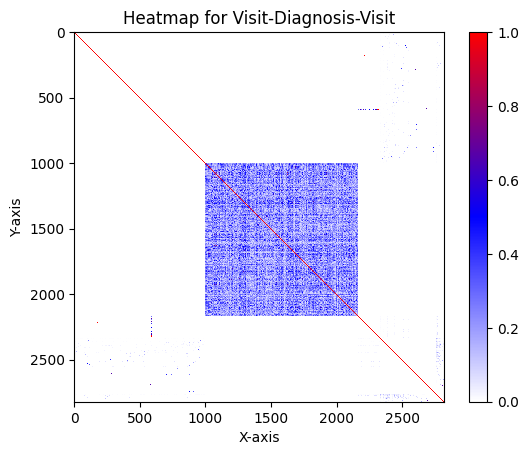

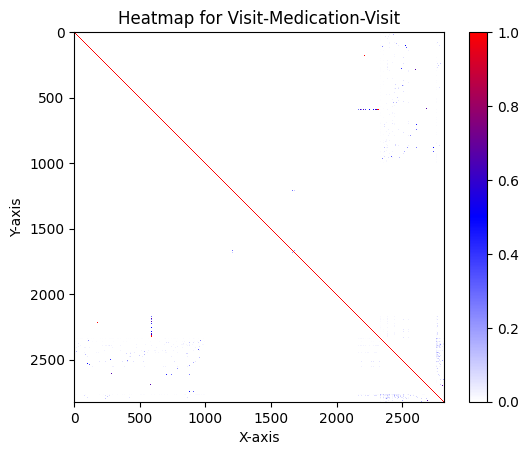

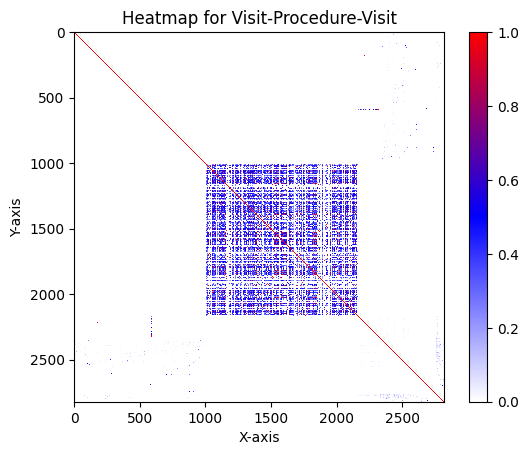

In [19]:
A = np.eye(N, N)
As1 = [A, VDV_A, DVM_A, CVM_A, CVP_A, CVD_A, MVP_A, DVP_A]
As2 = [A, VMV_A, DVM_A, CVM_A, CVP_A, CVD_A, MVP_A, DVP_A]
As3 = [A, VPV_A, DVM_A, CVM_A, CVP_A, CVD_A, MVP_A, DVP_A]

A_meta1 = np.zeros((N,N))
for a in As1:
    A_meta1 +=a
heatmap(A_meta1, 'Visit-Diagnosis-Visit')

A_meta2 = np.zeros((N,N))
for a in As2:
    A_meta2 +=a
heatmap(A_meta2, 'Visit-Medication-Visit')

A_meta3 = np.zeros((N,N))
for a in As3:
    A_meta3 +=a
heatmap(A_meta3, 'Visit-Procedure-Visit')


# Lenght of stay (LOS)

In [20]:
Y = newDF[['HADM_ID', 'LOS']].set_index('HADM_ID')['LOS'].to_dict()

Nodes = list(HG.nodes())
X = np.random.randn(len(Nodes), 128)
# X = np.eye(Total_number_of_nodes)

num_features = X.shape[1]
G = None
G = nx.Graph()
for v in Nodes:
    i = Nodes.index(v)
    node_attributes = {'y': 99999, 'x': X[i]}
    if v[0]=='V':
        node_attributes = {'y': Y[int(v[2:])], 'x': X[i]}
        # print(v, Y[int(v[2:])])
    if len(v)<2:
        print(v)
    G.add_node( v, **node_attributes)

for i in range(len(Nodes)-1):
    for j in range(i + 1, len(Nodes)):
        G.add_edge(Nodes[i], Nodes[j], weight=A_meta1[i, j])

In [21]:
c, v, m, p, d = 0,0,0,0,0
for n in Nodes:
    if n[0]=='V':
        v+=1
    if n[0]=='C':
        c+=1
    if n[0]=='M':
        m+=1
    if n[0]=='P':
        p+=1
    if n[0]=='D':
        d+=1

print(f'Patients = {c}\nVisits = {v}\nMedications = {m}\nProcedures = {p}\nDiagnosis = {d}\nTotal = {c+v+m+d+p}')

    

Patients = 998
Visits = 1171
Medications = 164
Procedures = 63
Diagnosis = 425
Total = 2821


In [22]:
data = from_networkx(G)
data


c:\Anaconda3\envs\GNNenv\Lib\site-packages\torch_geometric\utils\convert.py:249: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  data[key] = torch.tensor(value)


Data(x=[2821, 128], edge_index=[2, 7955220], y=[2821], weight=[7955220])

## Creating new masks out of patient nodes only

In [23]:
data.y
newY = []
total = 0
for i,v in enumerate(list(data.y)):
    if v!=99999:
        newY.append([i,v])
        total+=1

y_train, y_left = train_test_split(newY    , train_size=0.7, random_state=42)
y_val,   y_test = train_test_split(y_left  , test_size=2/3, random_state=42)

# Create masks for train, validation, and test sets
train_mask = np.zeros(len(data.y), dtype=bool)
val_mask = np.zeros(len(data.y), dtype=bool)
test_mask = np.zeros(len(data.y), dtype=bool)

for i,v in y_train:
    train_mask[i] = True

for i,v in y_val:
    val_mask[i] = True

for i, v in y_test:
    test_mask[i] = True

print(train_mask.shape)
print(val_mask.shape)
print(test_mask.shape)
print('Train = ', sum([1 if v else 0 for v in train_mask])/total)
print('Val = ', sum([1 if v else 0 for v in val_mask])/total)
print('Test = ', sum([1 if v else 0 for v in test_mask])/total)

(2821,)
(2821,)
(2821,)
Train =  0.6994022203245089
Val =  0.09991460290350128
Test =  0.20068317677198974


In [24]:
data.train_mask = train_mask
data.test_mask  = test_mask
data.val_mask   = val_mask

Epoch: 010, Train Loss: 168.666, Val Acc: 0.060
Epoch: 020, Train Loss: 135.391, Val Acc: 0.060


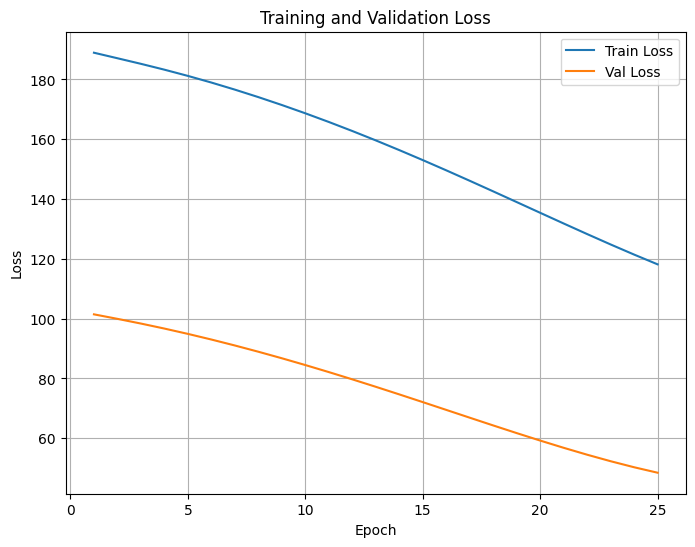

[(0, 8.0),
 (0, 9.0),
 (0, 5.0),
 (0, 4.0),
 (0, 24.0),
 (0, 7.0),
 (0, 13.0),
 (0, 14.0),
 (0, 7.0),
 (0, 7.0),
 (0, 12.0),
 (0, 57.0),
 (0, 4.0),
 (0, 10.0),
 (0, 4.0),
 (0, 16.0),
 (0, 27.0),
 (0, 8.0),
 (0, 5.0),
 (0, 11.0),
 (0, 9.0),
 (0, 21.0),
 (0, 12.0),
 (0, 8.0),
 (0, 13.0),
 (0, 10.0),
 (0, 5.0),
 (0, 10.0),
 (0, 7.0),
 (0, 5.0),
 (0, 5.0),
 (0, 6.0),
 (0, 7.0),
 (0, 5.0),
 (0, 22.0),
 (0, 8.0),
 (0, 9.0),
 (0, 24.0),
 (0, 19.0),
 (0, 13.0),
 (0, 5.0),
 (0, 15.0),
 (0, 27.0),
 (0, 4.0),
 (0, 7.0),
 (0, 21.0),
 (0, 7.0),
 (0, 1.0),
 (0, 6.0),
 (0, 8.0),
 (0, 2.0),
 (0, 8.0),
 (0, 4.0),
 (0, 17.0),
 (0, 7.0),
 (0, 6.0),
 (0, 3.0),
 (0, 5.0),
 (0, 3.0),
 (0, 9.0),
 (0, 0.0),
 (0, 10.0),
 (0, 17.0),
 (0, 13.0),
 (0, 20.0),
 (0, 8.0),
 (0, 10.0),
 (0, 8.0),
 (0, 1.0),
 (0, 7.0),
 (0, 13.0),
 (0, 8.0),
 (0, 8.0),
 (0, 17.0),
 (0, 3.0),
 (0, 12.0),
 (0, 13.0),
 (0, 34.0),
 (0, 5.0),
 (0, 6.0),
 (0, 10.0),
 (0, 17.0),
 (0, 6.0),
 (0, 7.0),
 (0, 10.0),
 (0, 4.0),
 (0, 5.0),
 (0, 28.

In [33]:
import GNNModel as GNNM
import torch

data.x = data.x.float()
data.y = data.y.float()

# Check if a GPU is available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data = data.to(device)
gcn = GNNM.GCNRegression(data.num_node_features).to(device)

optimizer_gcn = torch.optim.Adam(gcn.parameters(), lr=0.01, weight_decay=5e-4)
# criterion = torch.nn.CrossEntropyLoss()
criterion = nn.MSELoss()
gcn, df = GNNM.train_node_classifier(gcn, data, optimizer_gcn, criterion, n_epochs=25)
# ----------------------------------------------------------------------------

pred = gcn(data).argmax(dim=1)

pred = pred[data.test_mask] .detach().cpu().numpy()
correct = data.y[data.test_mask].detach().cpu().numpy()

[(pred[i], correct[i]) for i in range(len(correct))]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


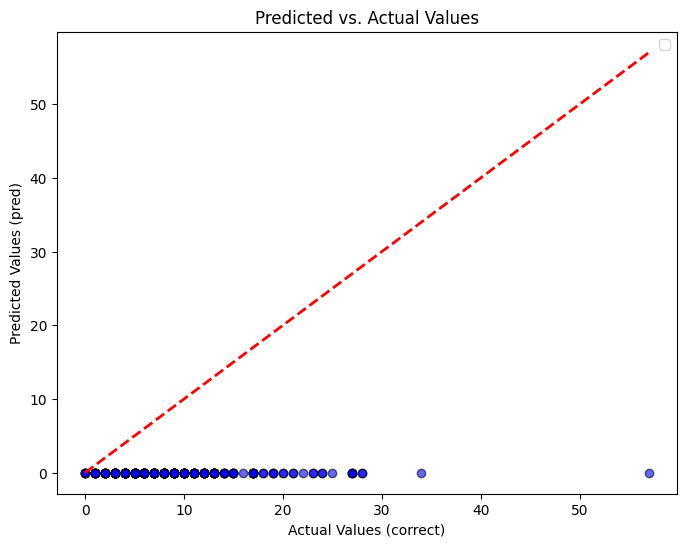

In [31]:
import matplotlib.pyplot as plt

# Assuming you have already defined 'pred' and 'correct'

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(correct, pred, c='blue', alpha=0.6, edgecolors='k')

# Add labels and title
plt.xlabel('Actual Values (correct)')
plt.ylabel('Predicted Values (pred)')
plt.title('Predicted vs. Actual Values')

# Add a diagonal line for reference (perfect prediction)
plt.plot([min(correct), max(correct)], [min(correct), max(correct)], linestyle='--', color='red', linewidth=2)
plt.legend()
# Show the plot
plt.show()


In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Actual target values (ground truth)
actual_values = correct

# Predicted values from your regression model
predicted_values = pred

# Calculate and print Mean Absolute Error (MAE)
mae = mean_absolute_error(actual_values, predicted_values)
print(f"Mean Absolute Error (MAE): {mae:.2f}")

# Calculate and print Mean Squared Error (MSE)
mse = mean_squared_error(actual_values, predicted_values)
print(f"Mean Squared Error (MSE): {mse:.2f}")

# Calculate and print Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Calculate and print R-squared (R²)
r_squared = r2_score(actual_values, predicted_values)
print(f"R-squared (R²): {r_squared:.2f}")


# GNNM.create_confusion_matrix(pred, correct)


# test_acc, _ = GNNM.eval_node_classifier(gcn, data, data.test_mask)
# print(f'Test Acc: {test_acc:.3f}\n')

Mean Absolute Error (MAE): 9.00
Mean Squared Error (MSE): 129.78
Root Mean Squared Error (RMSE): 11.39
R-squared (R²): -1.66
